### Logistic Regression models

**Objective**: This notebook aims to analyse customer reviews using Logistic Regression models to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed Logistic Regression with L1 regularisation to optimise the model's performance, which helps in feature selection by penalising less important features. The data is vectorised using 1 and 2-grams to capture the context within the text effectively. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset and compare the results.

**Key Findings**: The top three words associated with positive reviews are "love", "great" and "perfect". The top three words associated with negative reviews are "return", "broke" and "waste". This is consistant between both models. The model on unbalanced data scored an accuracy of $0.72$, and the model on balanced data achieved an accuracy of $0.79$. More analysis takes place in the notebook.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format="retina"

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, auc

from source import downsample_binary, my_tokenizer
import joblib

import lime
import lime.lime_tabular

In [24]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

Begin by reading in the data, then I will optimise for best C value using $L1$ Regression. Before doing this, I will split the data into test and train, and make a copy of the train set before downsampling the majority class. I will train two logistic regressions on each dataset and compare the results. I am using the vectorisation with 1 and 2-grams

In [25]:
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")


In [26]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
test_later = X_test

In [28]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

In [29]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [30]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]



In [16]:
X_train_bal_unvec.shape, y_train_bal.shape


((271596,), (271596,))

In [11]:
X_train.duplicated().sum()

62367

In [12]:
y_train.value_counts(normalize=True)

binary
1    0.761183
0    0.238817
Name: proportion, dtype: float64

In [12]:
# checking that the downsample worked
y_train.value_counts(), y_train_bal.value_counts()

(binary
 1    432829
 0    135798
 Name: count, dtype: int64,
 binary
 0    135798
 1    135798
 Name: count, dtype: int64)

### Optimizing a Logistic Regression on the original unbalanced data


In [13]:
# instansiate the pipeline
estimators = [('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe = Pipeline(estimators)


In [25]:
# run a grid search for the model on unbalanced data
params = {
    'model__penalty':['l1'],
    'model__solver':['liblinear'],
    'model__C': [0.1,1,10,15],
    'model__random_state':[42]    
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [26]:
# fit the grid search
fittedgrid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.5min
[CV 2/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.858 total time= 2.6min
[CV 3/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.856 total time= 2.2min
[CV 4/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.3min
[CV 5/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.5min
[CV 1/5] END model__C=1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.4min
[CV 3/5] END

In [ ]:
fittedgrid.best_estimator_

In [ ]:

estimators = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators, verbose=True)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 4.0min
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.7s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x169999700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x169999700>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [150]:
len(pipe_final[0].get_feature_names_out())

600

### Optimizing a Logistic Regression on the balanced data


In [14]:
# instansiate the balanced pipeline
estimators_bal = [
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_bal = Pipeline(estimators_bal)

In [15]:
# run a grid search for the model on balanced data
params_bal = {
    'model__C': [0.1,1,10],
    'model__random_state':[42]
    
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [ ]:
fittedgrid_bal = grid_search_bal.fit(X_train, y_train)

In [ ]:
fittedgrid_bal.best_estimator_

In [ ]:
estimators_bal = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final_bal  = Pipeline(estimators_bal, verbose=True)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

## Analysis

We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [32]:
log_clas = pipe_final[-1]
log_clas_bal = pipe_final_bal[-1]

In [33]:
# predictions for unbalanced
y_pred_train = pipe_final.predict(X_train_unvec)
y_pred_test = pipe_final.predict(X_test_unvec)

In [34]:
# predictions for balanced
y_pred_train_bal = pipe_final_bal.predict(X_train_bal_unvec)
y_pred_test_bal = pipe_final_bal.predict(X_test_unvec)


In [35]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [36]:
accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test)

(0.7348244103779806, 0.7341882566458212)

In [37]:
accuracy_score(y_train_bal, y_pred_train_bal),accuracy_score(y_test, y_pred_test_bal)

(0.8237013799908688, 0.8170895559135323)

## Plotting highest coefficients for positive and negative sentiment

In [21]:
log_clas.coef_.shape

(1, 600)

In [22]:
X_train.columns

Index(['1gram__10', '1gram__100', '1gram__6s', '1gram__abl', '1gram__absolut',
       '1gram__access', '1gram__actual', '1gram__ad', '1gram__adapt',
       '1gram__add',
       ...
       '2gram__well made', '2gram__work fine', '2gram__work good',
       '2gram__work great', '2gram__work like', '2gram__work perfectli',
       '2gram__work well', '2gram__would buy', '2gram__would definit',
       '2gram__would recommend'],
      dtype='object', length=600)

In [40]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=pipe_final[0].get_feature_names_out()
).sort_values("coefficients", ascending=False)
# word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

# plt.title("The 20 highest model coefficients indicating positive sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [241]:
# word_counts.head(5).plot(kind="bar", figsize=(10, 5), legend=False)

# plt.title("The 5 highest model coefficients indicating positive sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

We can see that the model identifies these words as the top words sigifying positive signal. This is reasonable as these words are positive

In [41]:
word_counts2 = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=pipe_final[0].get_feature_names_out()
).sort_values("coefficients", ascending=True)

# word_counts2.head(50).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

# plt.title("The 20 highest model coefficients indicating negative sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [243]:
# word_counts2.head(5).abs().plot(kind="bar", figsize=(10, 5), legend=False, color='red')

# plt.title("The 5 highest model coefficients indicating negative sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

Here are the top 5 words signifiying negative reviews. 

In [42]:
p = word_counts.head(5)
n = word_counts2.head(5)
p.columns = ['pos']
n.columns = ['neg']
p_and_n = pd.concat([p,n])
p_and_n

,pos,neg
1gram__love,8.217851,NaN
1gram__expect,6.894379,NaN
1gram__phone,6.706986,NaN
1gram__happen,6.483171,NaN
1gram__awesom,6.378915,NaN
1gram__review,NaN,-5.346347
1gram__wast,NaN,-4.929243
1gram__doesnt,NaN,-4.707119
1gram__broke,NaN,-3.999686
1gram__strong,NaN,-3.840492


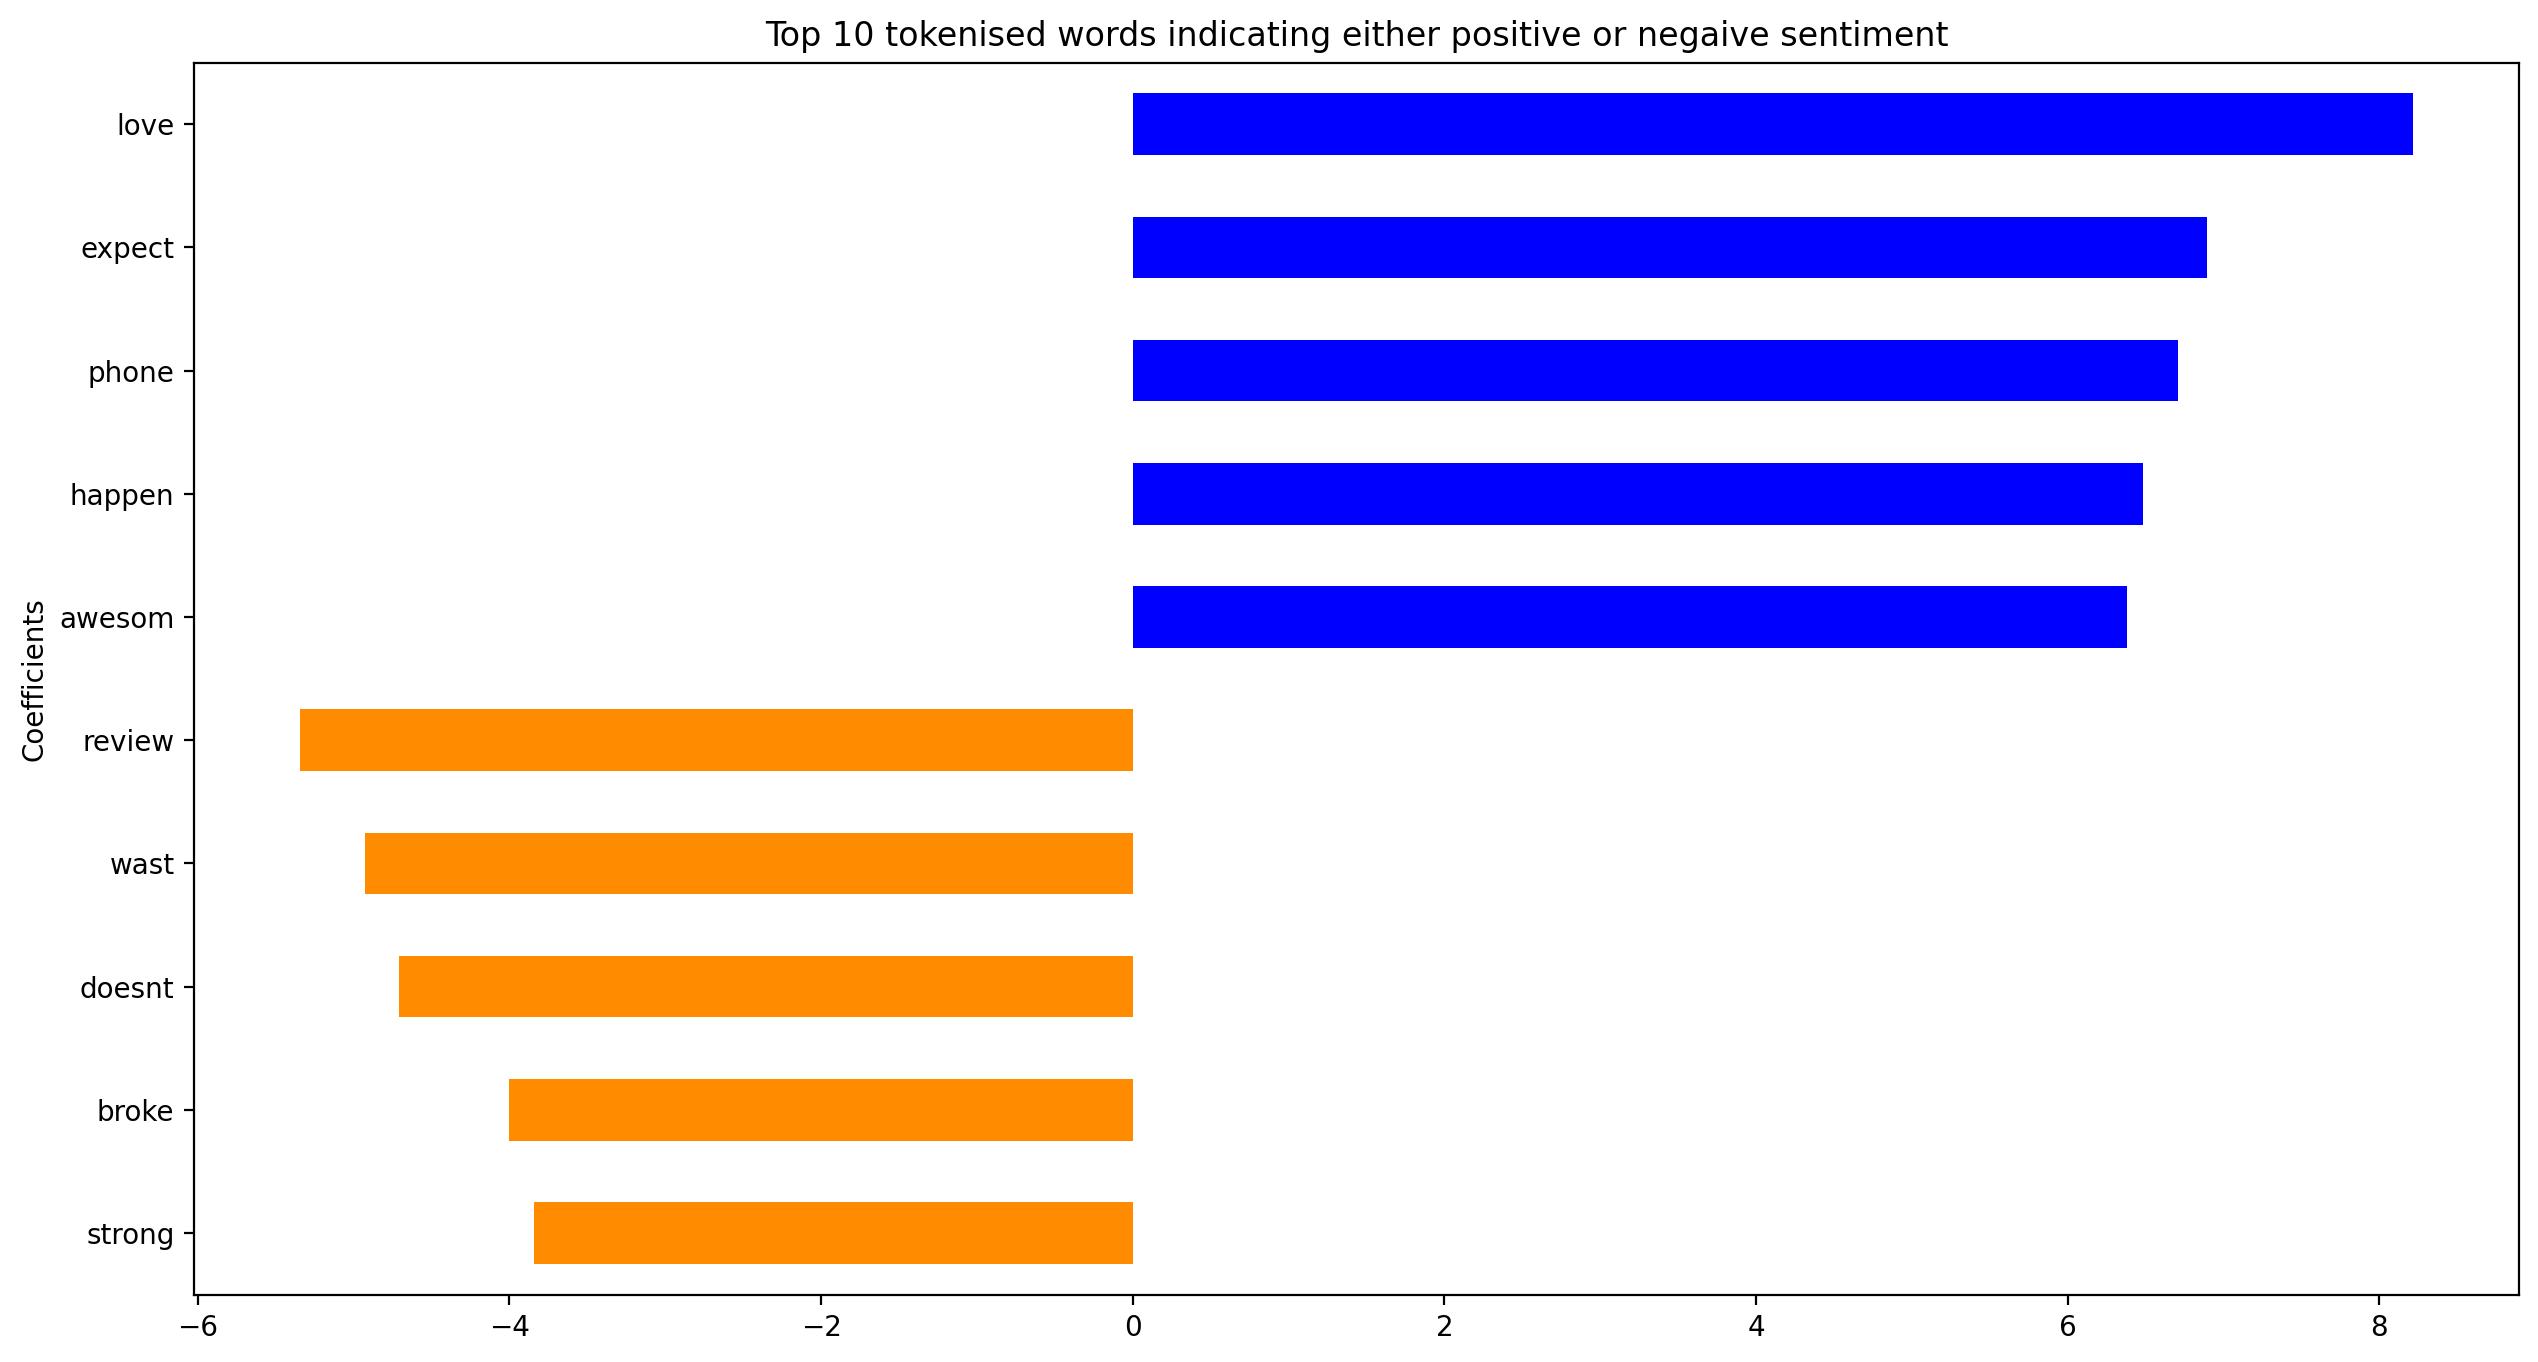

In [43]:
# coloring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data = p_and_n.stack().reset_index()
stacked_data.columns = ['feature', 'type', 'coefficient']
stacked_data
sorted_data = stacked_data.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['blue' if tp=="pos"  else 'darkorange' for tp in sorted_data['type']]
sorted_data['feature'] = sorted_data['feature'].str.replace('1gram__', '').str.replace('2gram__', '')

# plot
plt.figure(figsize=(15,8))
sorted_data.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Top 10 tokenised words indicating either positive or negaive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=0)
plt.show()

REVIEW, waste, doesnt broke strong all negative, love, expect, phone, happen

The same results for the balanced data, but in a slightly different order. It is interesting that no 2-grams were chosen as very important. maybe this was an unececary step and we can test this in future.

In [44]:
word_counts_bal = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=pipe_final_bal[0].get_feature_names_out()
).sort_values("coefficients", ascending=False)
word_counts.index = word_counts.index.str.replace('1gram__', '').str.replace('2gram__', '')

# word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

# plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [45]:
word_counts_bal2 = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=pipe_final_bal[0].get_feature_names_out()
).sort_values("coefficients", ascending=True)
word_counts.index = word_counts.index.str.replace('1gram__', '').str.replace('2gram__', '')

# word_counts.head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

# plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [46]:
p_bal = word_counts_bal.head(5)
n_bal = word_counts_bal2.head(5)
p_bal.columns = ['pos']
n_bal.columns = ['neg']
p_and_n_bal = pd.concat([p_bal,n_bal])
p_and_n_bal

,pos,neg
1gram__love,7.365310,NaN
1gram__excel,6.195482,NaN
1gram__awesom,5.911307,NaN
1gram__perfect,5.874647,NaN
1gram__great,5.726864,NaN
1gram__poor,NaN,-6.231235
1gram__horribl,NaN,-6.095548
1gram__return,NaN,-6.061782
1gram__terribl,NaN,-5.696547
1gram__useless,NaN,-5.693024


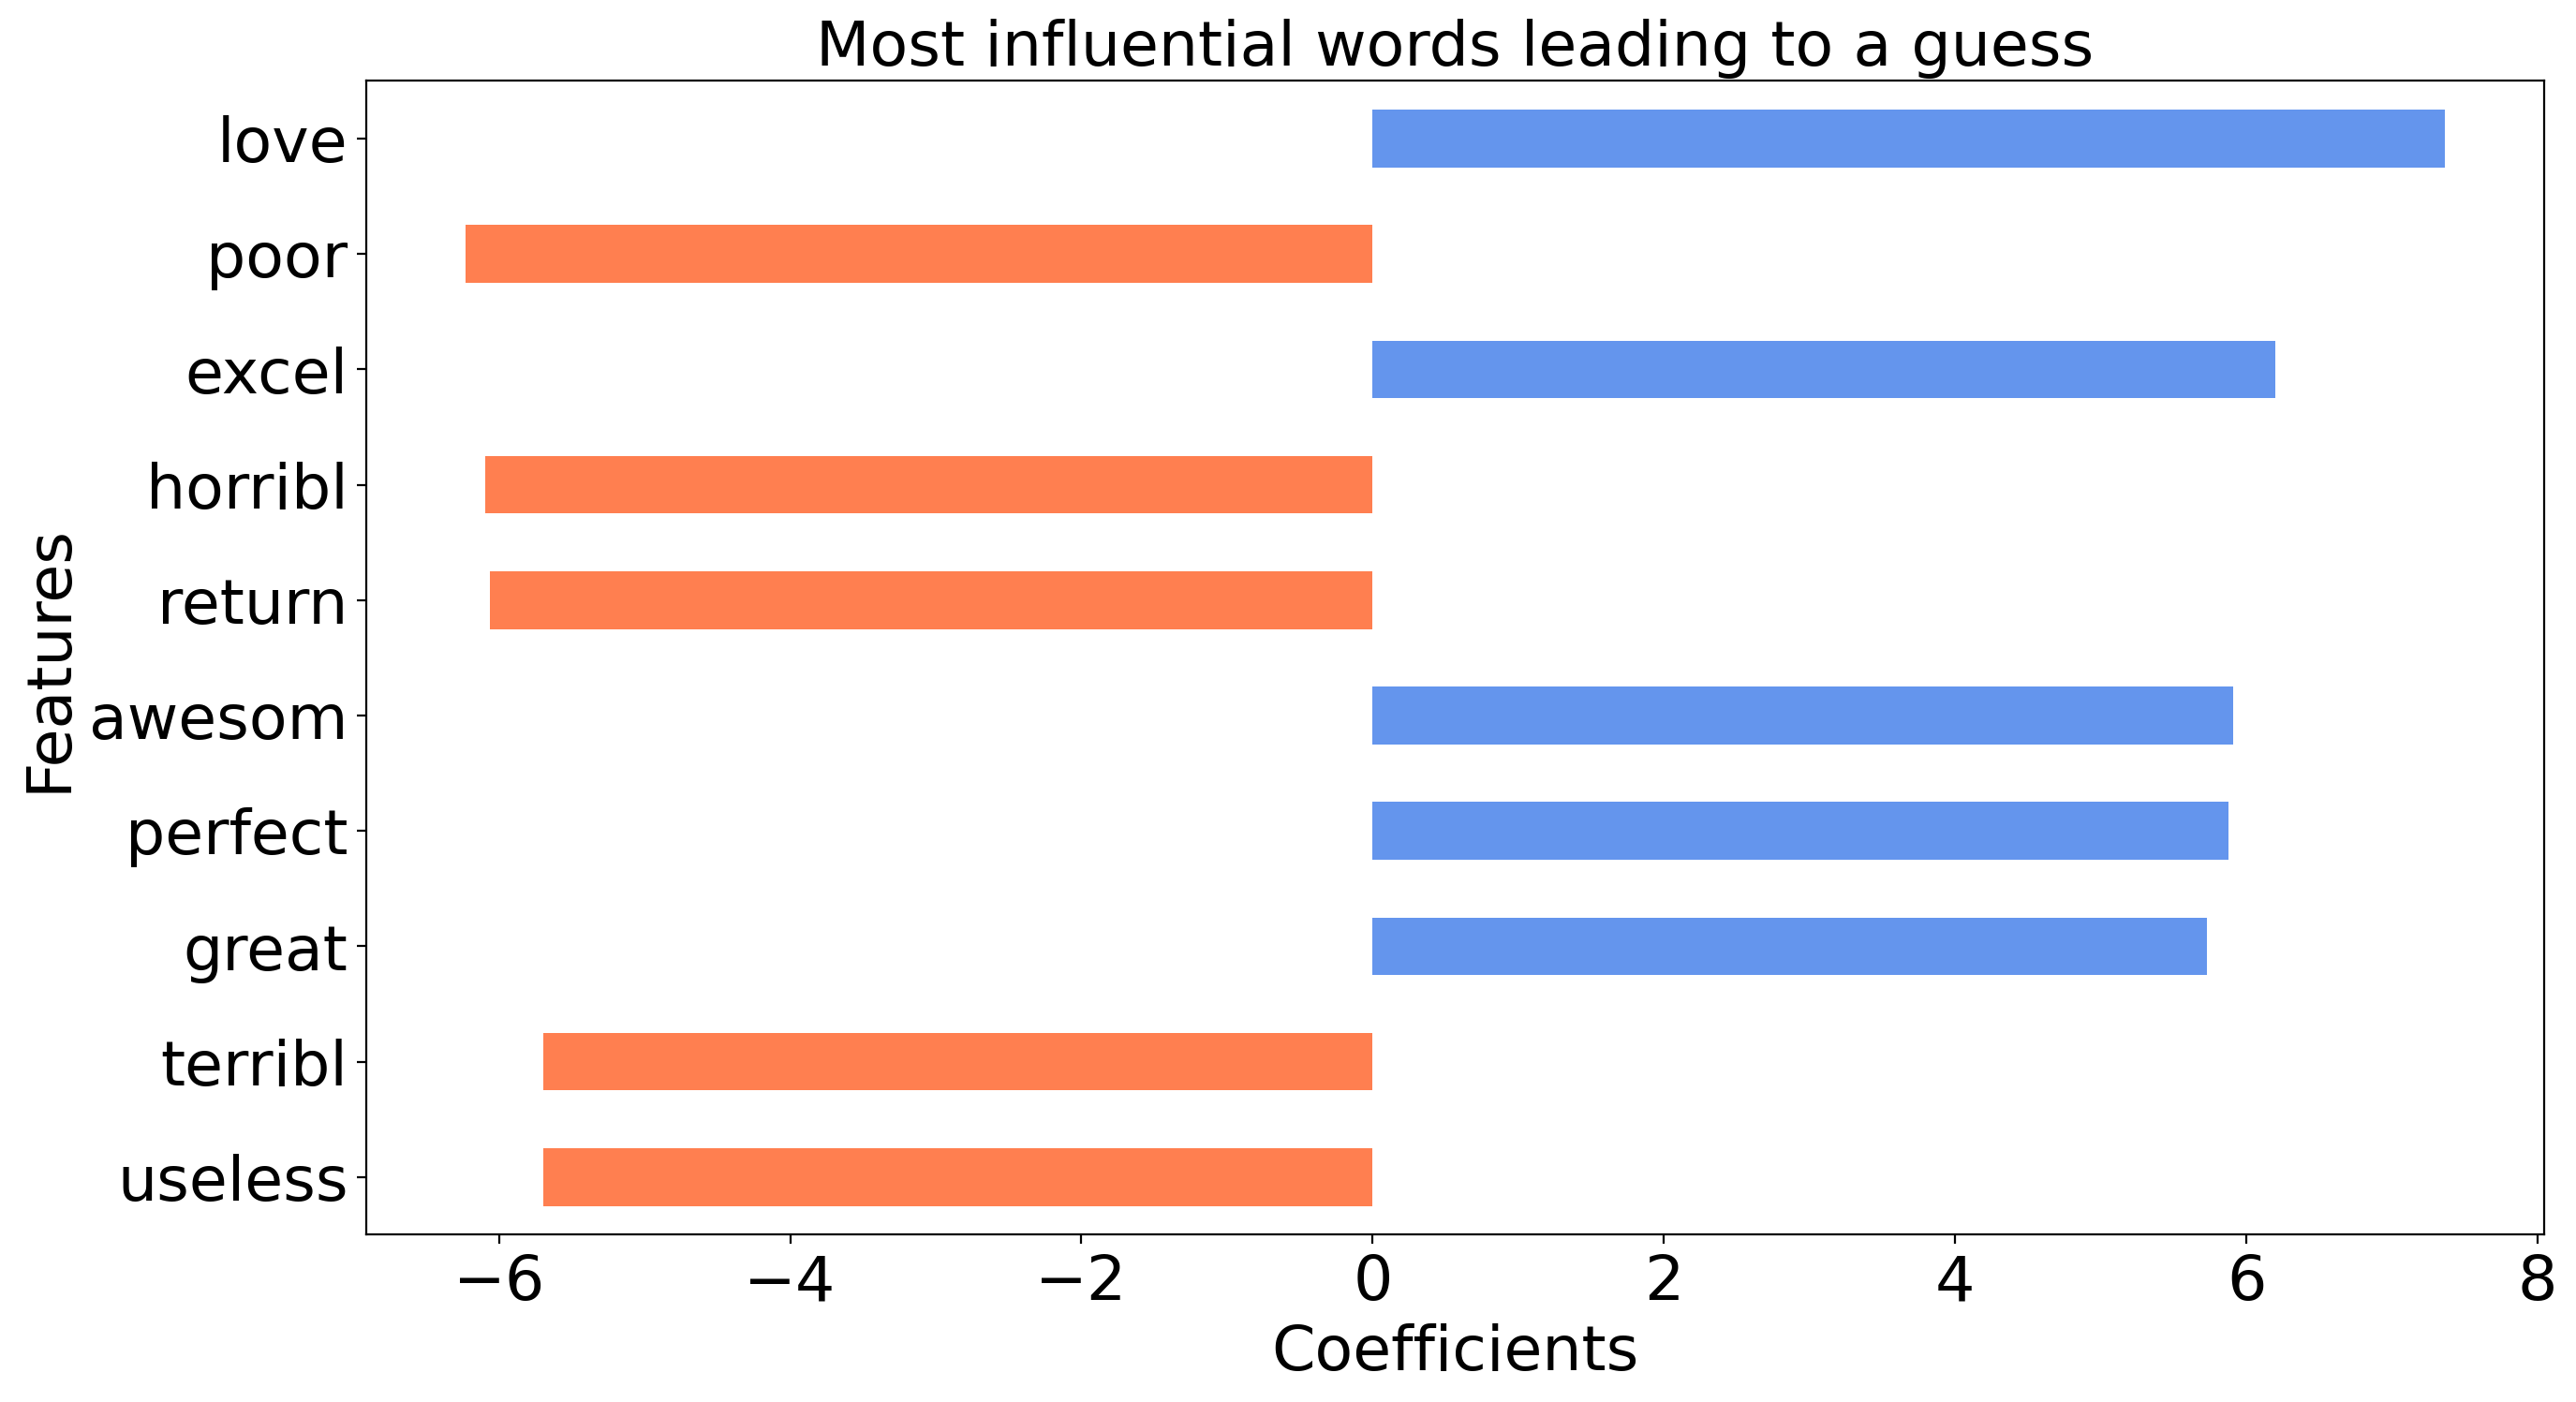

In [85]:
# coloring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data_bal = p_and_n_bal.stack().reset_index()
stacked_data_bal.columns = ['feature', 'type', 'coefficient']
stacked_data_bal
sorted_data_bal = stacked_data_bal.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['cornflowerblue' if tp=="pos"  else 'coral' for tp in sorted_data_bal['type']]
sorted_data_bal['feature'] = sorted_data_bal['feature'].str.replace('1gram__', '').str.replace('2gram__', '')

# plot
plt.figure(figsize=(15,8))
sorted_data_bal.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Most influential words leading to a guess", fontsize=24)
plt.ylabel("Features", fontsize=24)
plt.xlabel("Coefficients", fontsize=24)

plt.xticks(rotation=0, fontsize=24)
plt.yticks(rotation=0, fontsize=24)

plt.show()

We see that both in the positive and negative reviews the same words appear, although in slightly different orders. Many words we expect such as love, great, perfect indicate positive reviews, whilst words such as return waste dissapoint indicate a negative review. Lets look further into the predictions

In [31]:
joblib.dump(pipe_final, "../model/logistic-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/logistic-bal-model.pkl")



['../model/logistic-bal-model.pkl']

In [21]:
pipe_final = joblib.load("../model/logistic-unbal-model.pkl")
pipe_final_bal = joblib.load("../model/logistic-bal-model.pkl")



Confusion matrix

In [48]:
# unbalanced
cm = confusion_matrix(y_test, y_pred_test)
cm_norm = confusion_matrix(y_test, y_pred_test , normalize="true")

In [49]:
# balanced
cm_bal = confusion_matrix(y_test, y_pred_test_bal)
cm_bal_norm = confusion_matrix(y_test, y_pred_test_bal, normalize="true")

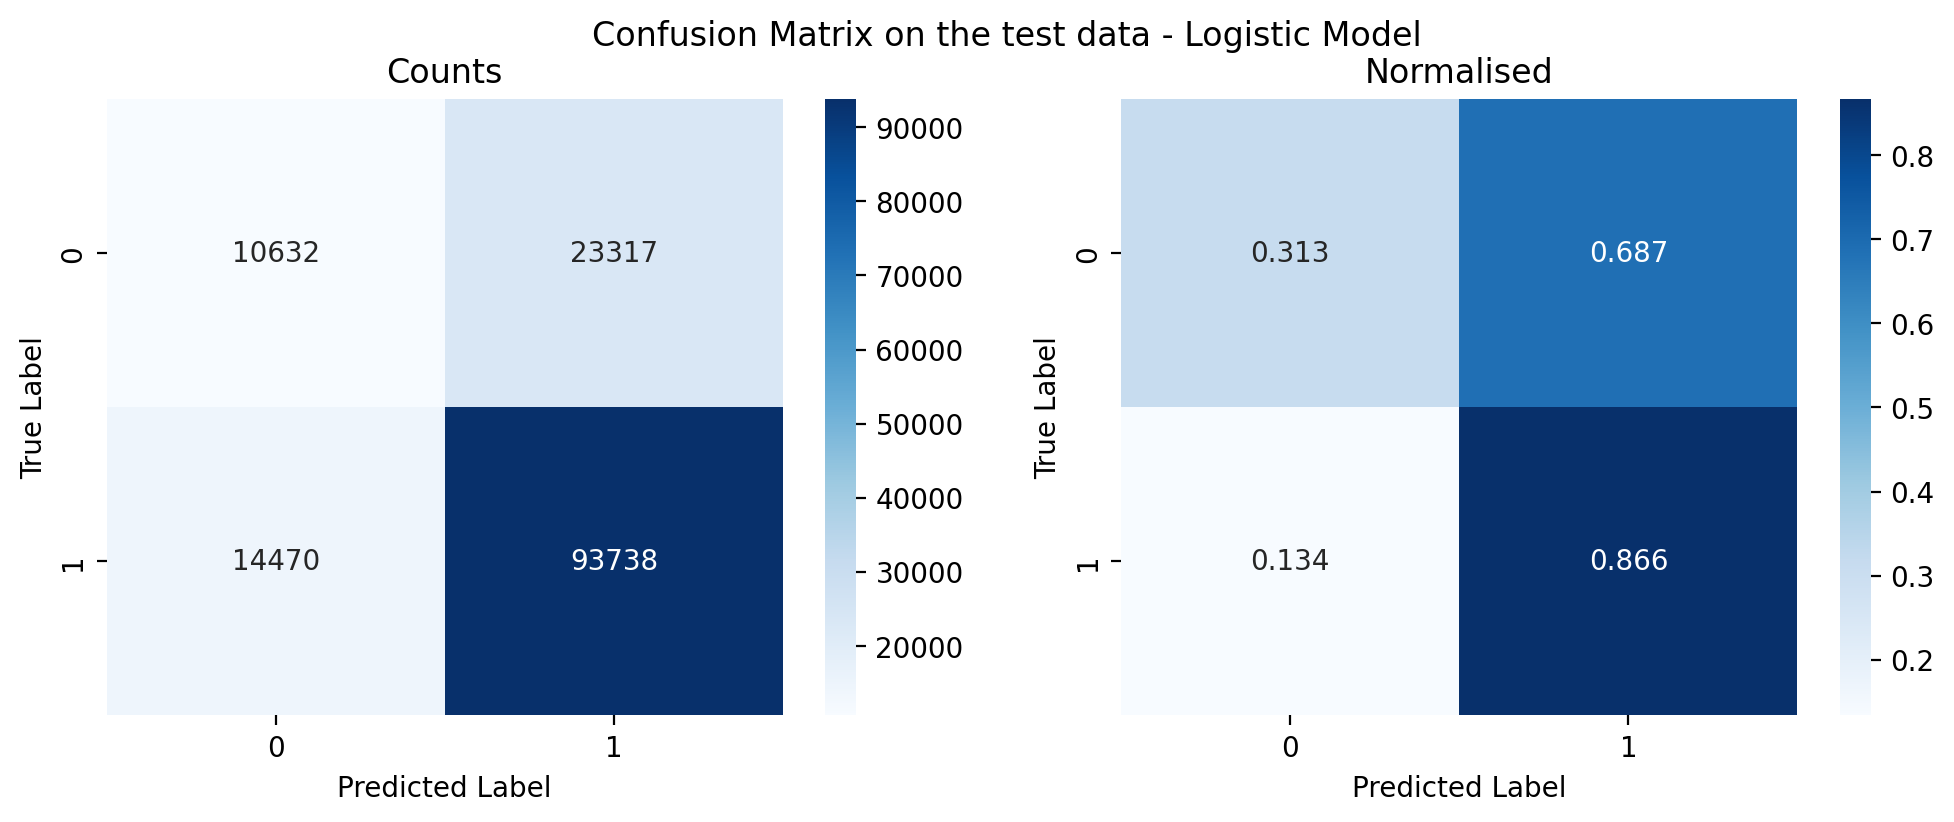

In [74]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Confusion Matrix on the test data - Logistic Model")
plt.show()


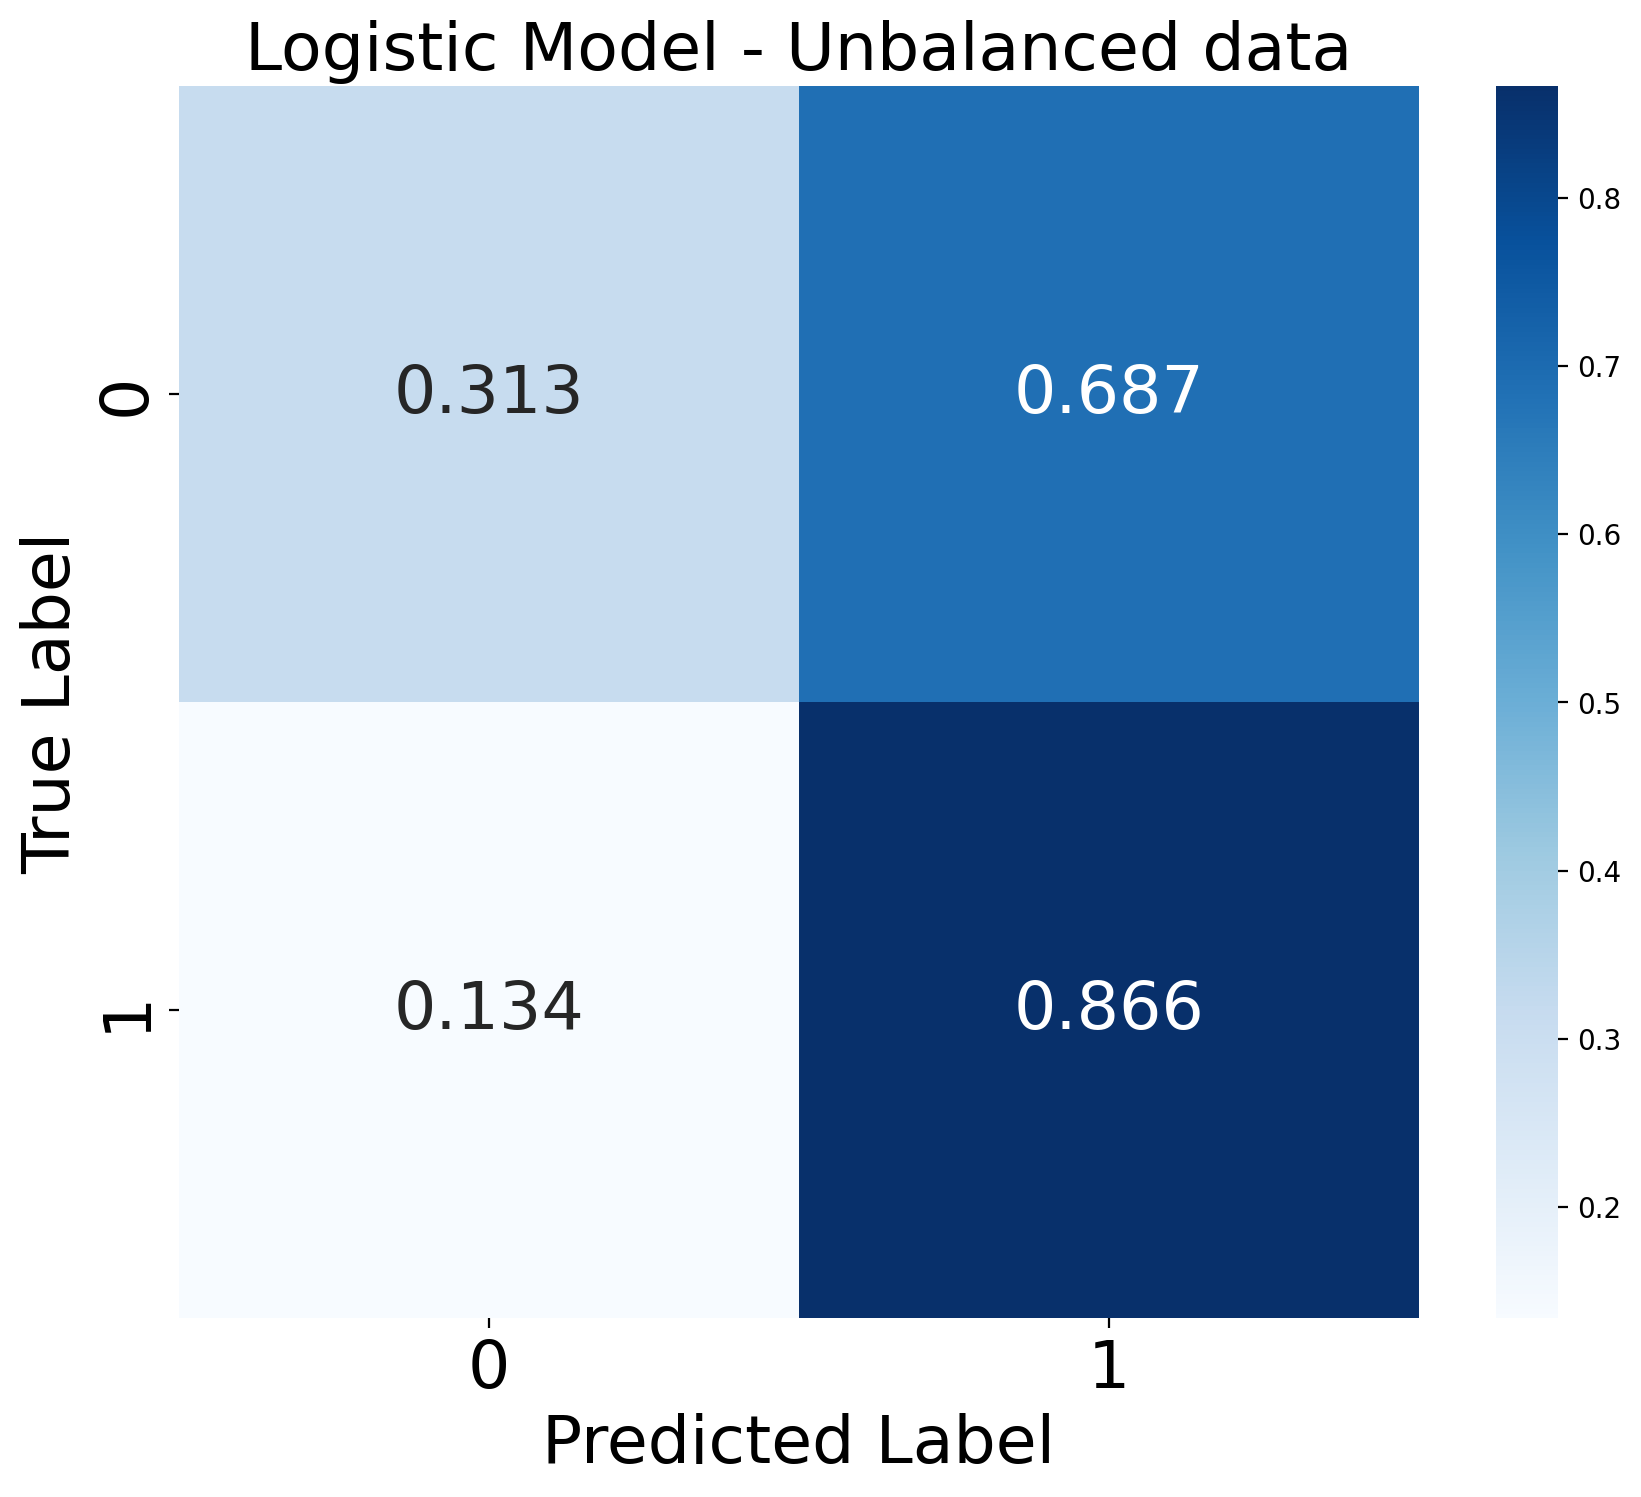

In [86]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues", annot_kws={"size":24})
plt.xlabel("Predicted Label", fontsize=24)
plt.ylabel("True Label", fontsize=24)
plt.title("Logistic Model - Unbalanced data", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

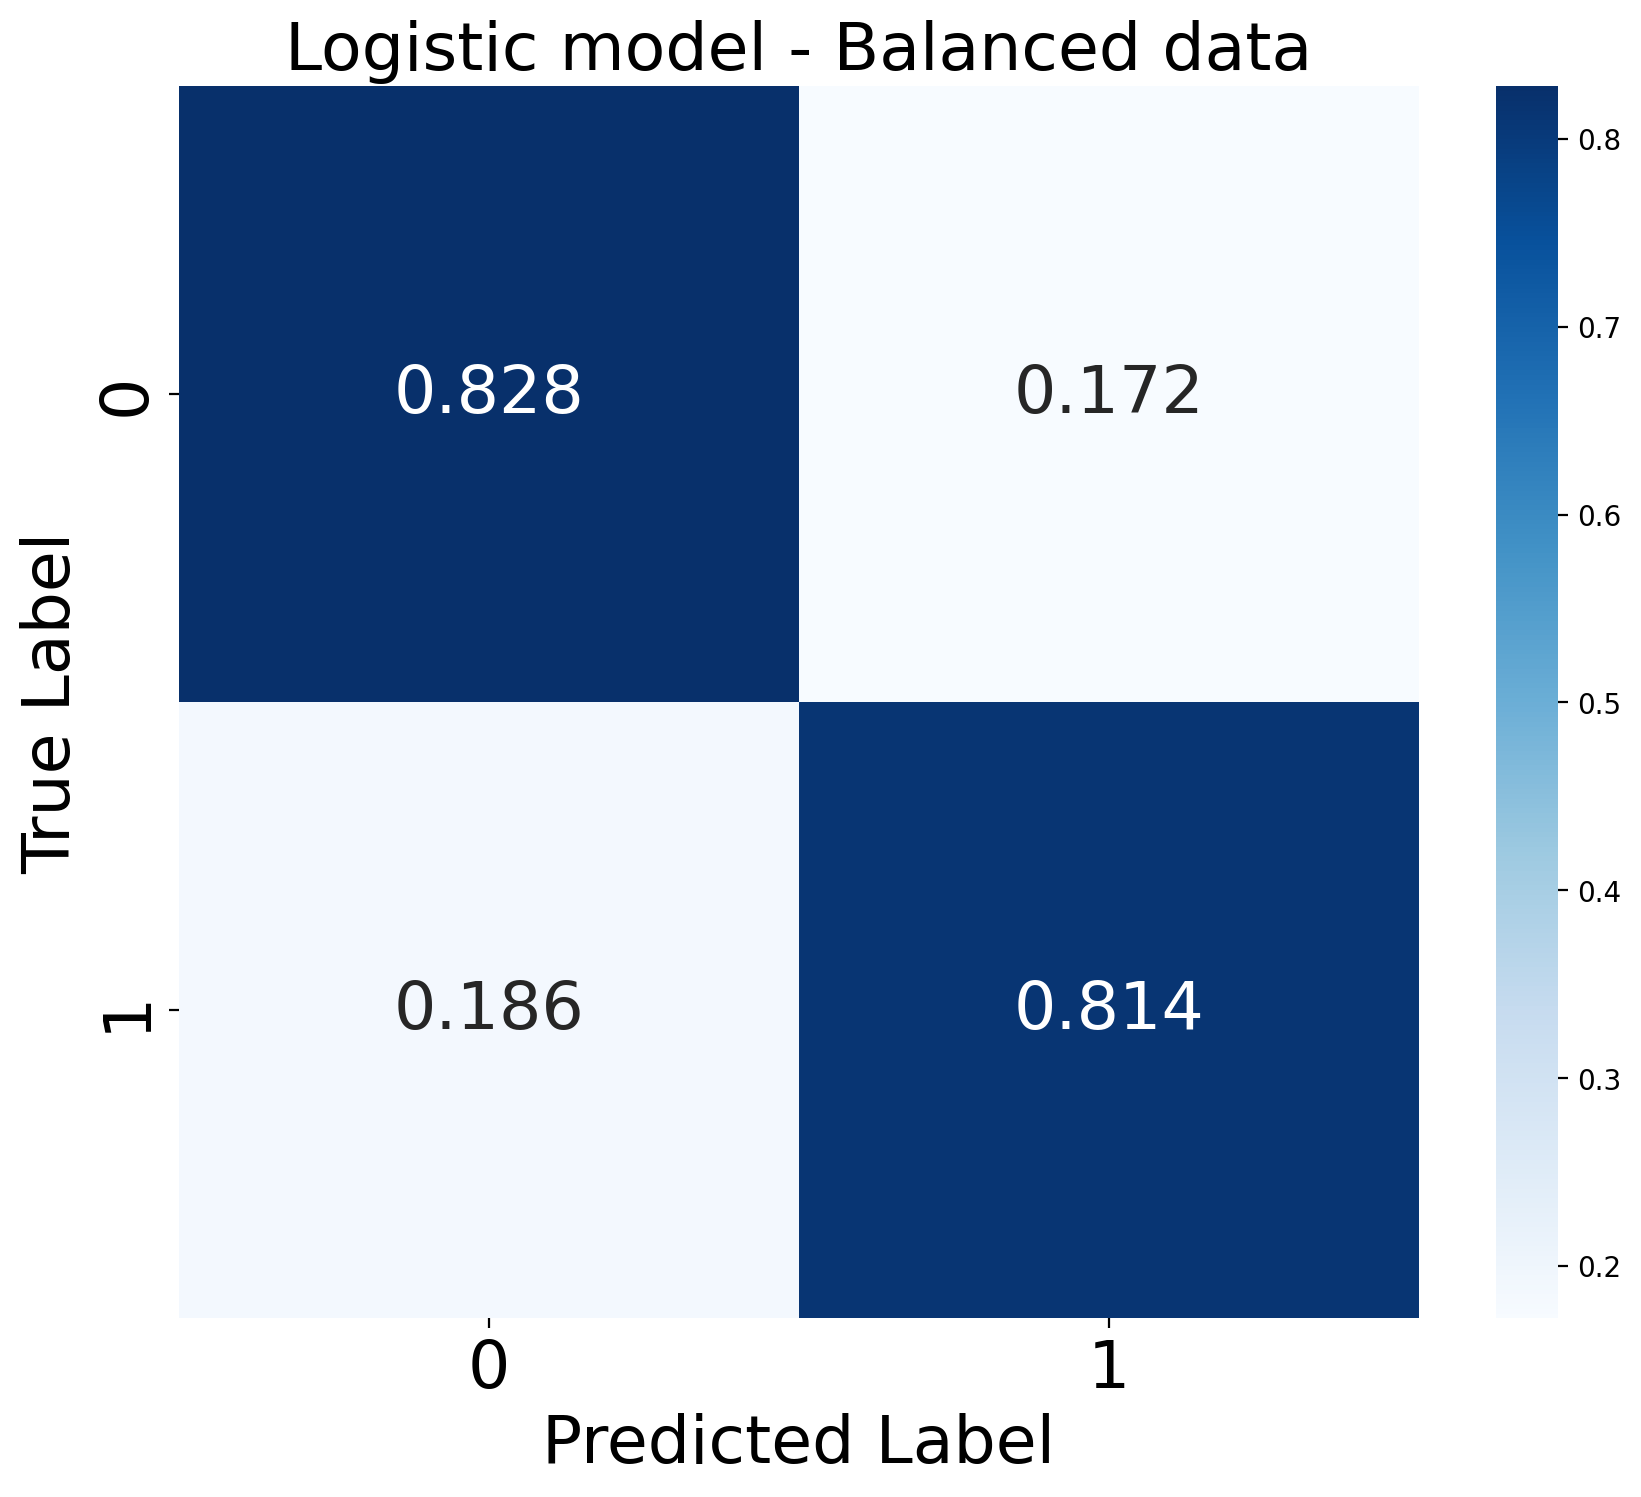

In [88]:
plt.figure(figsize=(10,8))

sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues", annot_kws={"size":24})
plt.xlabel("Predicted Label", fontsize=24)
plt.ylabel("True Label", fontsize=24)
plt.title("Logistic model - Balanced data", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

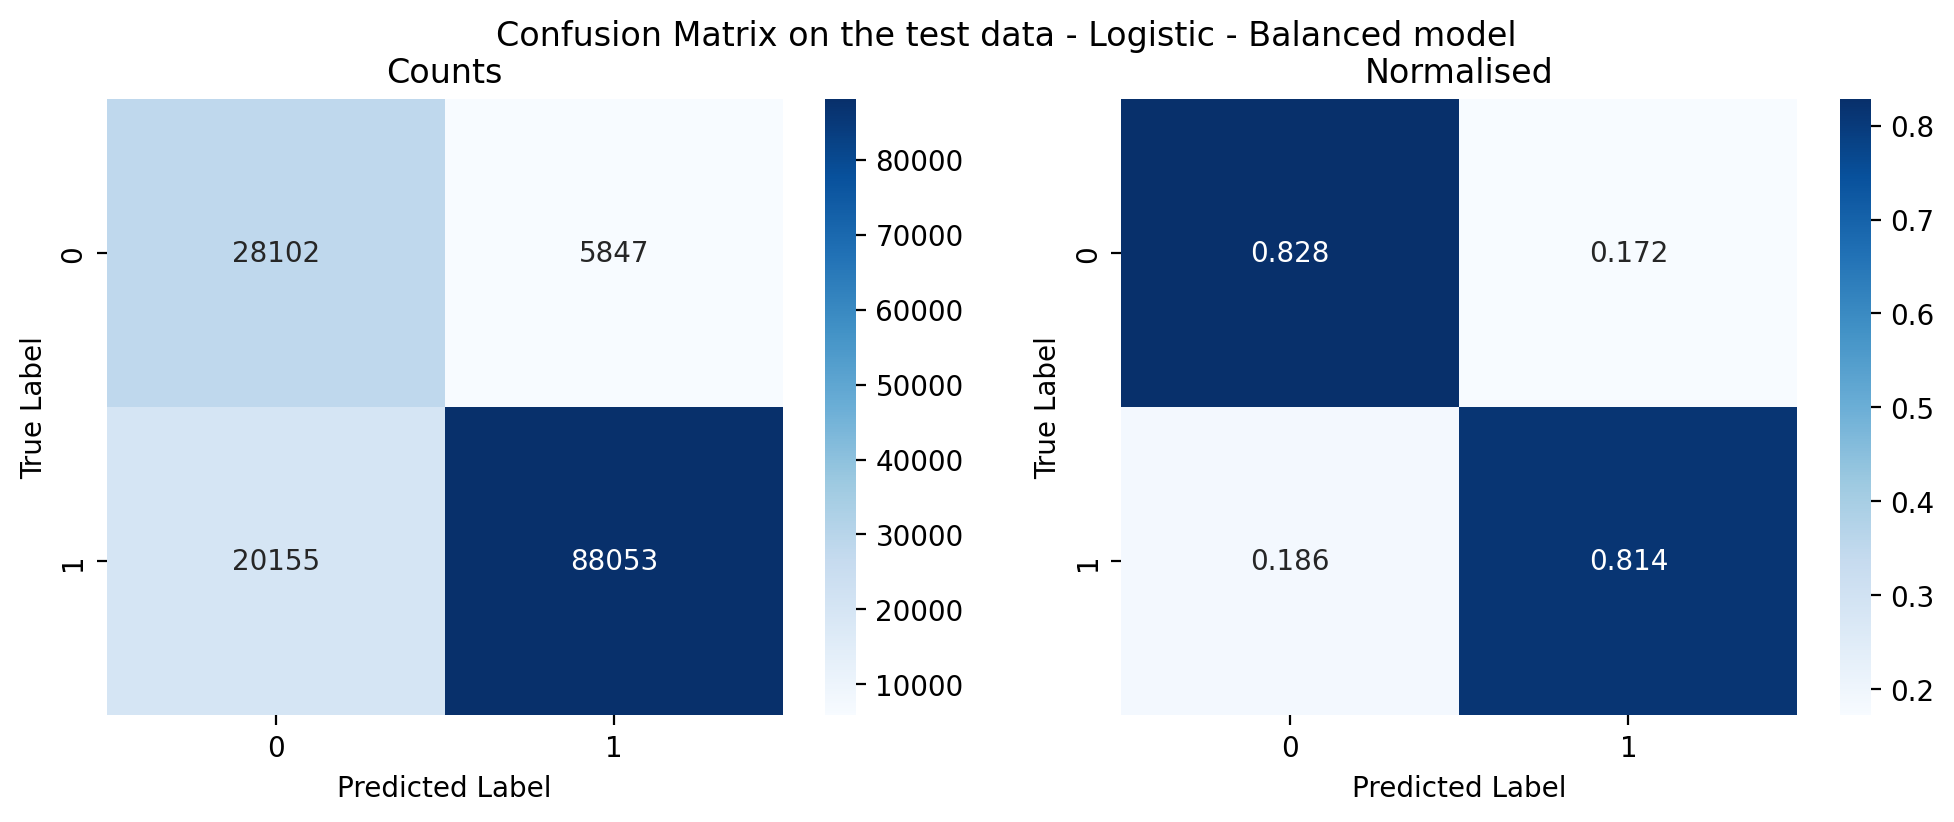

In [51]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Confusion Matrix on the test data - Logistic - Balanced model")
plt.show()


we see that the first logistic regression is very good at predicting negative reviews, which is interesting as there are very few of them in comparison. however, it has overfitted, and predicts many positive reviews as negative.

The regression on the balanced data does better on positive reviews and slightly worse on negative, hwoever, it gets less wrong overall

In [52]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [53]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


We can see how the ROC changes as we change the confidence thresehold. It shows we could try vary it and compare.

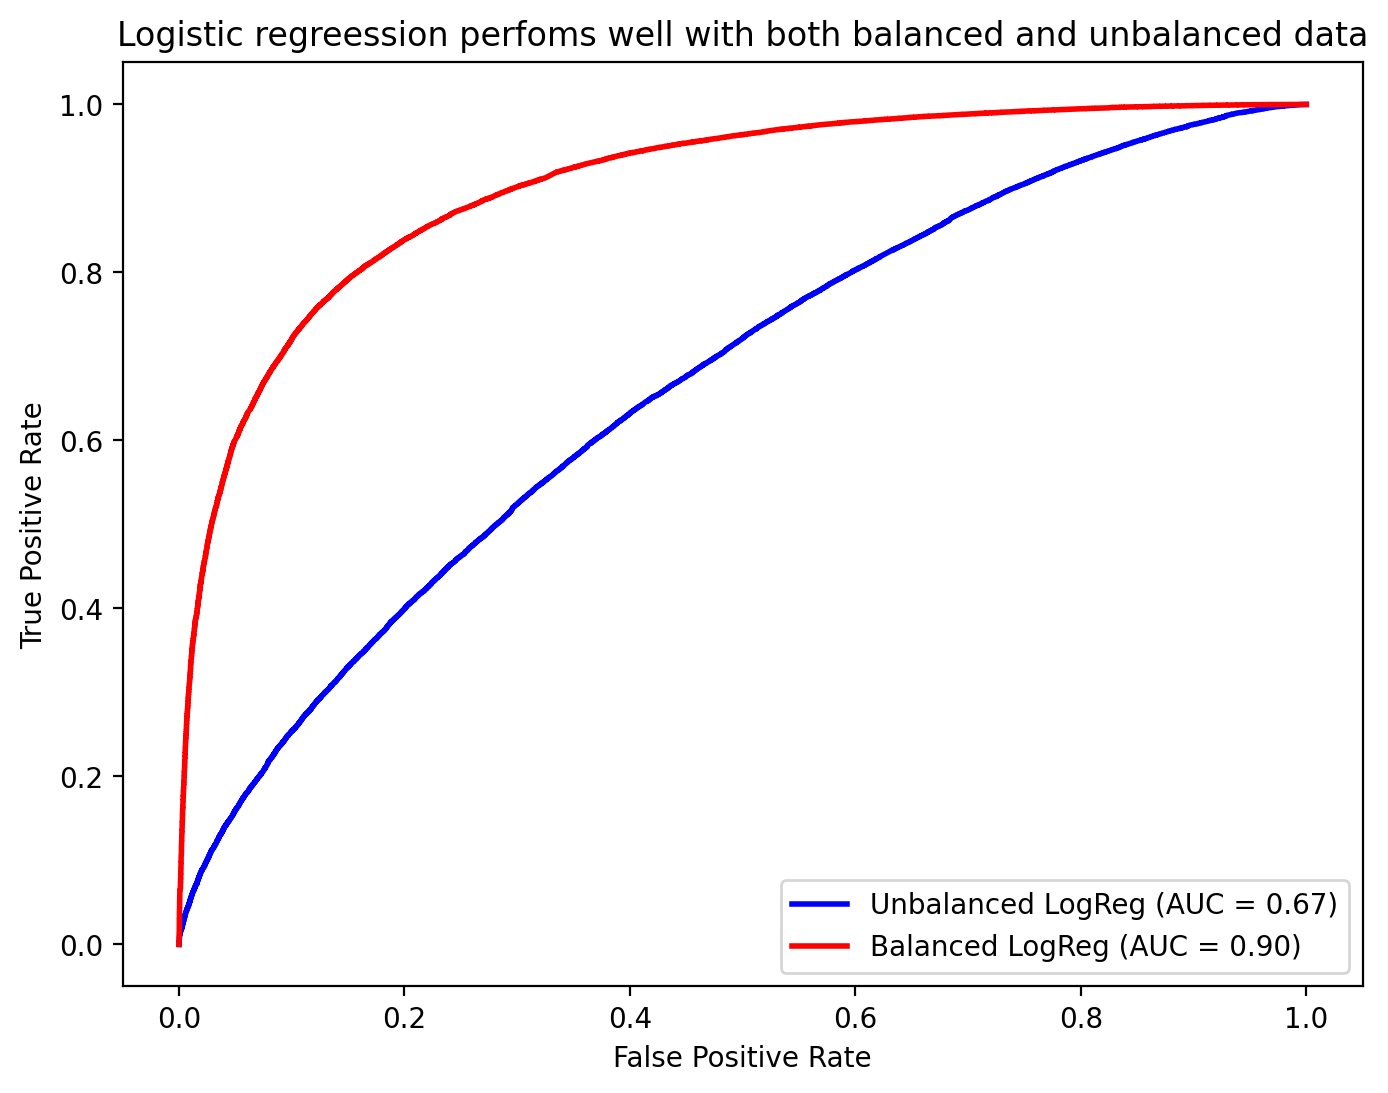

In [212]:
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced LogReg (AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced LogReg (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regreession perfoms well with both balanced and unbalanced data')
plt.legend()


plt.show()

In [246]:
with open('logreg_roc_data.pkl', 'wb') as f:
    joblib.dump({'fpr_unbal': fpr_unbal, 'tpr_unbal': tpr_unbal, 'roc_auc1': roc_auc1,
                 'fpr_bal': fpr_bal, 'tpr_bal': tpr_bal, 'roc_auc2': roc_auc2}, f)

Really poor precision of the 0 class, and bad recall on the 1 class. It "performs well" by guessing 0 a lot. Then when its very confident it guesses 1 and gets it right, but misclassifies many positive reviews as negative.

In [54]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.42      0.31      0.36     33949
           1       0.80      0.87      0.83    108208

    accuracy                           0.73    142157
   macro avg       0.61      0.59      0.60    142157
weighted avg       0.71      0.73      0.72    142157



In [55]:
print(classification_report(y_test, y_pred_test_bal))

              precision    recall  f1-score   support

           0       0.58      0.83      0.68     33949
           1       0.94      0.81      0.87    108208

    accuracy                           0.82    142157
   macro avg       0.76      0.82      0.78    142157
weighted avg       0.85      0.82      0.83    142157



Similar results, but better overall at guessing each class.

Understanding model mistakes:

In [274]:
y_pred_test_Ser = pd.Series(y_pred_test, index=y_test.index)


In [278]:

incorrect_guesses_unbal = y_test != y_pred_test

incorrect_v_unbal = pd.Series(y_test)[incorrect_guesses_unbal]
pred_df_unbal = pd.DataFrame(y_pred_test_bal,y_test.index)
pred_df_unbal
ig_unbal = pd.concat([pred_df_unbal[incorrect_guesses_unbal],pd.Series(incorrect_v_unbal), test_later[incorrect_guesses_unbal]], axis=1)
ig_unbal.rename(columns={0:"guess"}, inplace=True)

In [276]:
rev_unbal = ig_unbal.loc[412231]
text_u = rev_unbal["reviewText"]
print(f"Actual: {rev_unbal['binary']}, Guess: {rev_unbal[0]}, Overall: {int(rev_unbal['overall'])}")
print(f"Review: {text_u}")

Actual: 1, Guess: 0, Overall: 4
Review: Needed headphones for the gym. Tired of earbuds falling out when I ran or later down. These wrap around the back of the head and fit snug.


In [279]:

incorrect_guesses = y_test != y_pred_test_bal

incorrect_v = pd.Series(y_test)[incorrect_guesses]
pred_df = pd.DataFrame(y_pred_test_bal,y_test.index)
pred_df
ig = pd.concat([pred_df[incorrect_guesses],pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1)
ig.rename(columns={0:"guess"}, inplace=True)

In [345]:
false_positives = ig[ig["guess"]==1]

In [347]:
headphones = false_positives["reviewText"].str.contains("headphones")
headphones[headphones].index

Index([171732,  13940, 525993, 662701,  84591, 414774, 186493,  39044, 103957,
       298434,  39623, 520898, 171328, 489422, 102183, 382596,  72147, 368866,
       697284, 104093, 104070],
      dtype='int64')

a Review it got wrong
298434, 171328, 72147

In [379]:
rev = ig.loc[298434]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text}")

Actual: 0, Guess: 1, Overall: 2
Review: Bought second pair, only this time I bought it for my daughter and surprise only got the headphones wrapped  around with type and no additional size buds


In [380]:
feature_values = ig.loc[298434,"1gram__10":]


In [381]:
log_clas.coef_.shape

(1, 600)

In [382]:
coefficients = log_clas_bal.coef_[0]
contributions = feature_values * coefficients
contributions.sort_values(ascending=False)


1gram__got         0.686774
1gram__size        0.521376
1gram__bought      0.360354
1gram__headphon    0.067812
1gram__slim            -0.0
                     ...   
1gram__time       -0.039522
1gram__around     -0.073433
1gram__second     -0.077836
1gram__type       -0.104202
1gram__daughter   -0.131053
Name: 298434, Length: 600, dtype: object

In [383]:
pd.DataFrame(contributions.sort_values(ascending=False)).head(5)

,298434
1gram__got,0.686774
1gram__size,0.521376
1gram__bought,0.360354
1gram__headphon,0.067812
1gram__slim,-0.0


In [384]:
pd.DataFrame(contributions.sort_values(ascending=True)).head(6)

,298434
1gram__daughter,-0.131053
1gram__type,-0.104202
1gram__second,-0.077836
1gram__around,-0.073433
1gram__time,-0.039522
1gram__thing,-0.0


We see that the positive words swayed the confidence of the model and it misclassified it. Words like love.

In [385]:
intercept = log_clas_bal.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [386]:
probability

array([0.59129458])

In [377]:
feature_values_unbal = ig_unbal.loc[412231,"1gram__10":]


In [299]:
log_clas.coef_.shape

(1, 600)

In [300]:
coefficients = log_clas.coef_[0]
contributions = feature_values * coefficients
contributions.sort_values(ascending=False)


1gram__fall        1.947355
1gram__snug        0.625443
1gram__need        0.395914
1gram__headphon     0.13314
1gram__10              -0.0
                     ...   
1gram__havent          -0.0
1gram__headset          0.0
1gram__around     -0.161482
1gram__back       -0.270951
1gram__fit        -0.681823
Name: 412231, Length: 600, dtype: object

In [301]:
pd.DataFrame(contributions.sort_values(ascending=False)).head(5)

,412231
1gram__fall,1.947355
1gram__snug,0.625443
1gram__need,0.395914
1gram__headphon,0.13314
1gram__10,-0.0


In [302]:
pd.DataFrame(contributions.sort_values(ascending=True)).head(5)

,412231
1gram__fit,-0.681823
1gram__back,-0.270951
1gram__around,-0.161482
1gram__size,0.0
1gram__sleek,0.0


In [303]:
intercept = log_clas.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [304]:
probability

array([0.90444394])

SHAP:


In [231]:
import shap
shap.initjs()


In [232]:
pipe_final

Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x17dee1700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x17dee1700>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [260]:
explainer = shap.Explainer(
    pipe_final[1], X_train, feature_names=pipe_final[0].get_feature_names_out(), index=X_train.index
)
shap_values = explainer(X_test)

In [246]:
print("Positive" if y_test[412231] else "Negative", "Review:")
print(y_test[412231])

Positive Review:
1


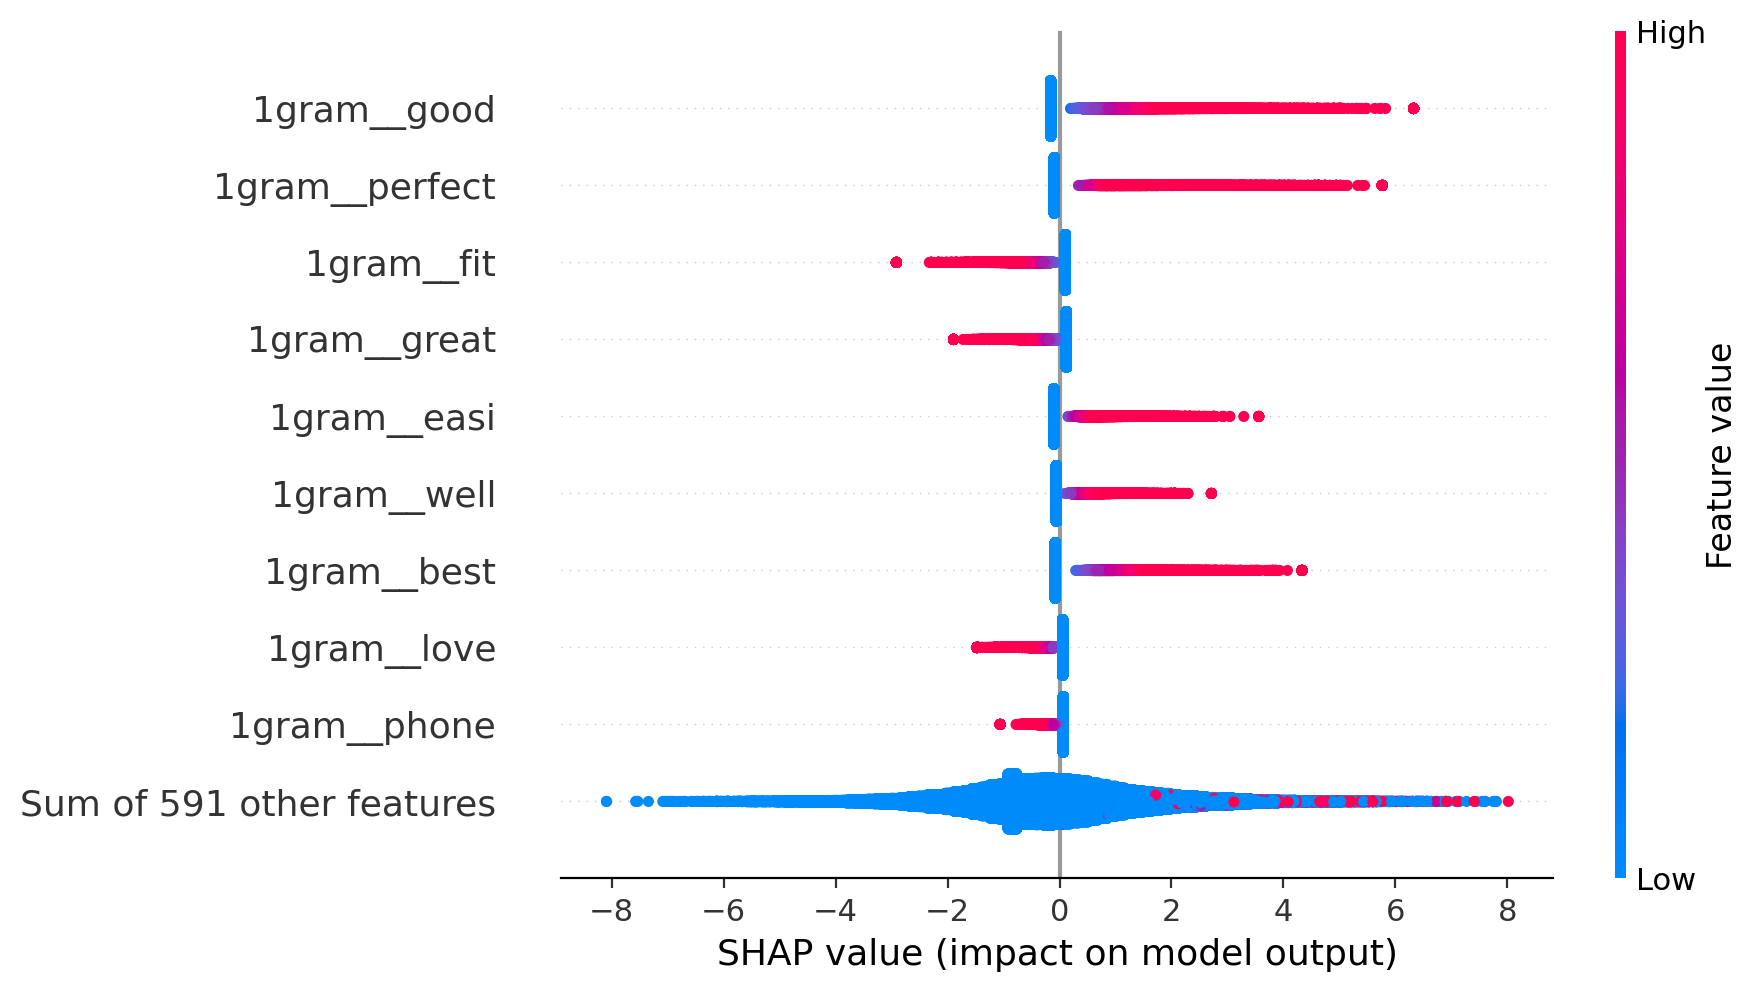

In [235]:
shap.plots.beeswarm(shap_values)

In [248]:
position = X_test.index.get_loc(412231)



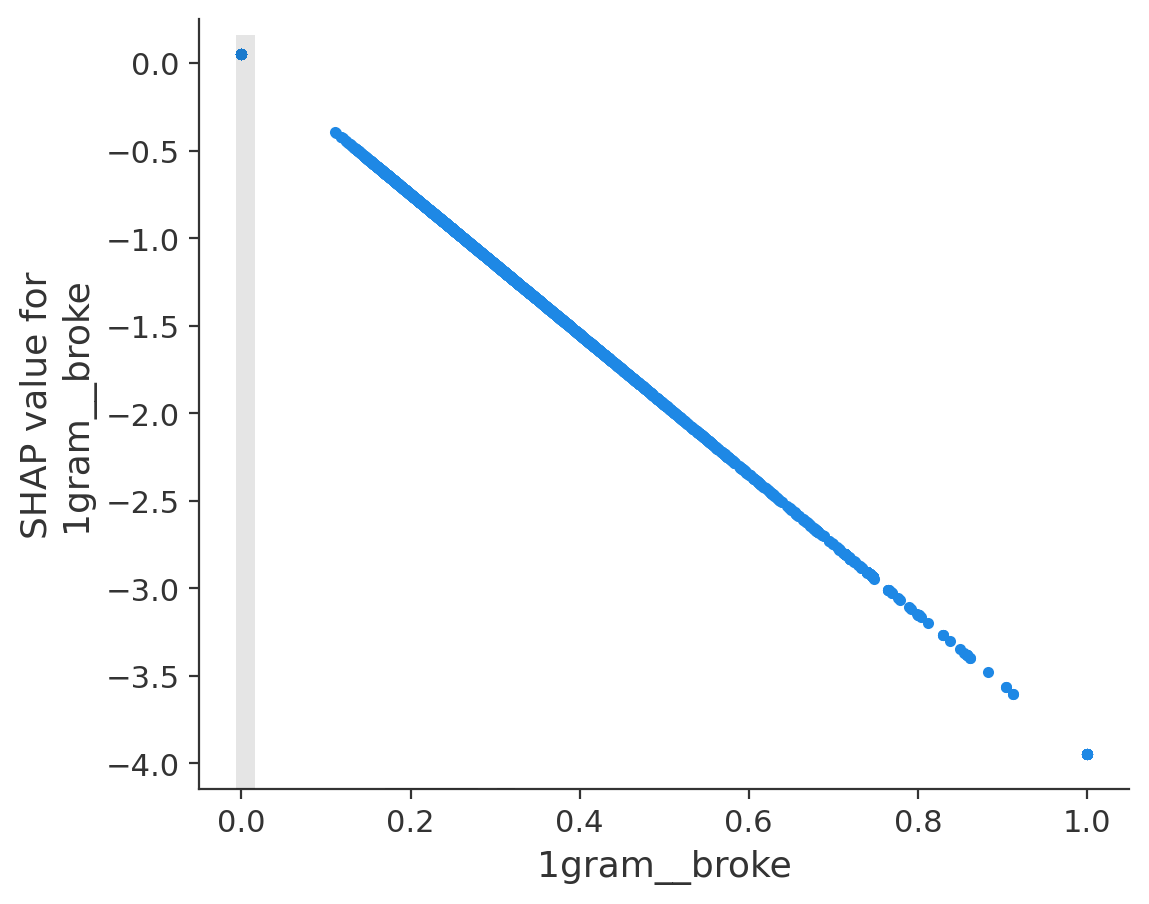

In [249]:
shap.plots.scatter(shap_values[:,"1gram__broke"])


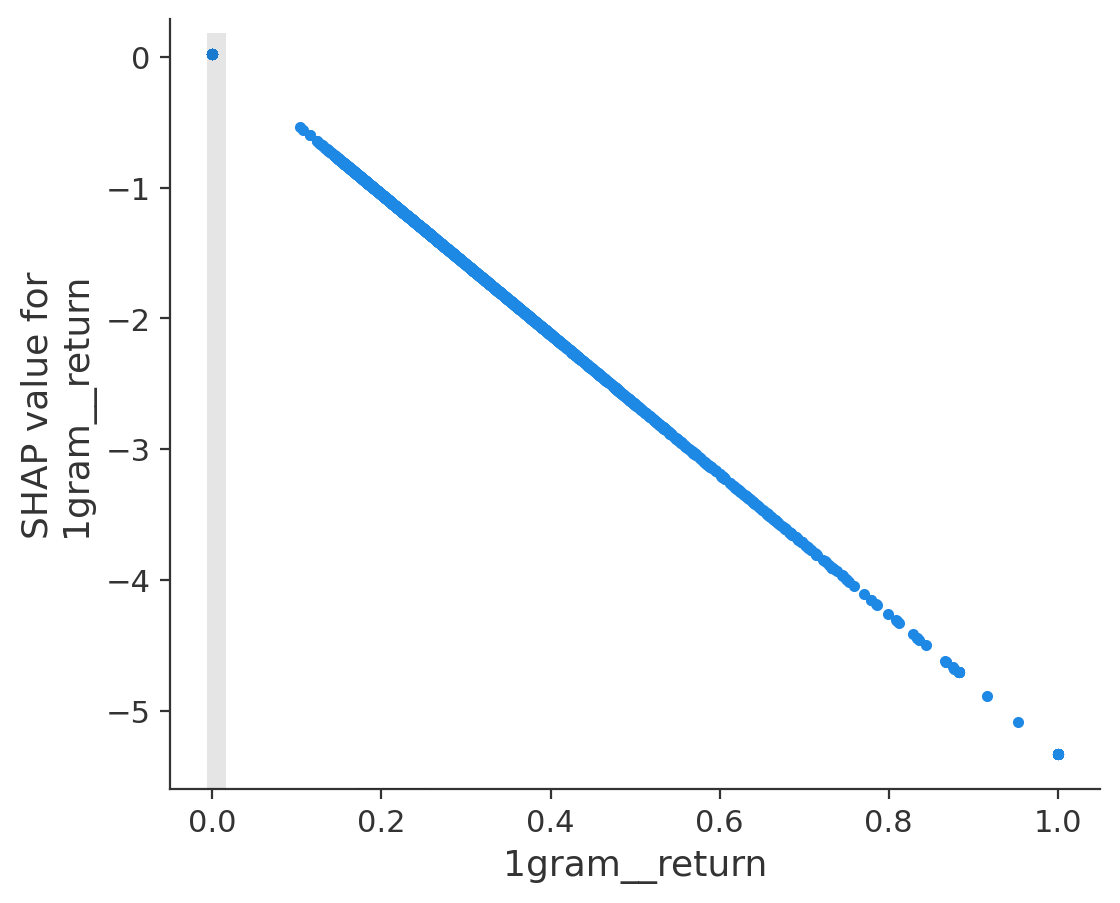

In [250]:
shap.plots.scatter(shap_values[:,"1gram__return"])


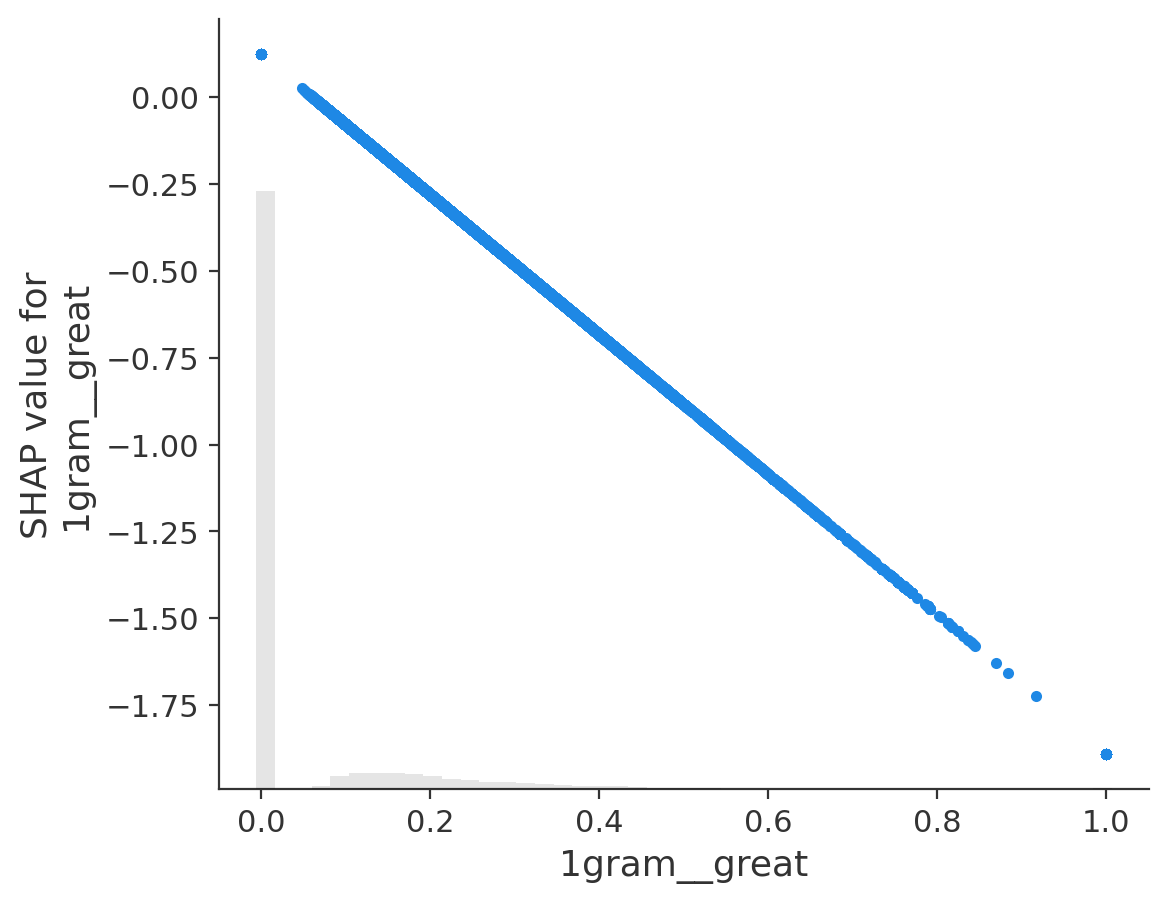

In [251]:
shap.plots.scatter(shap_values[:,"1gram__great"])


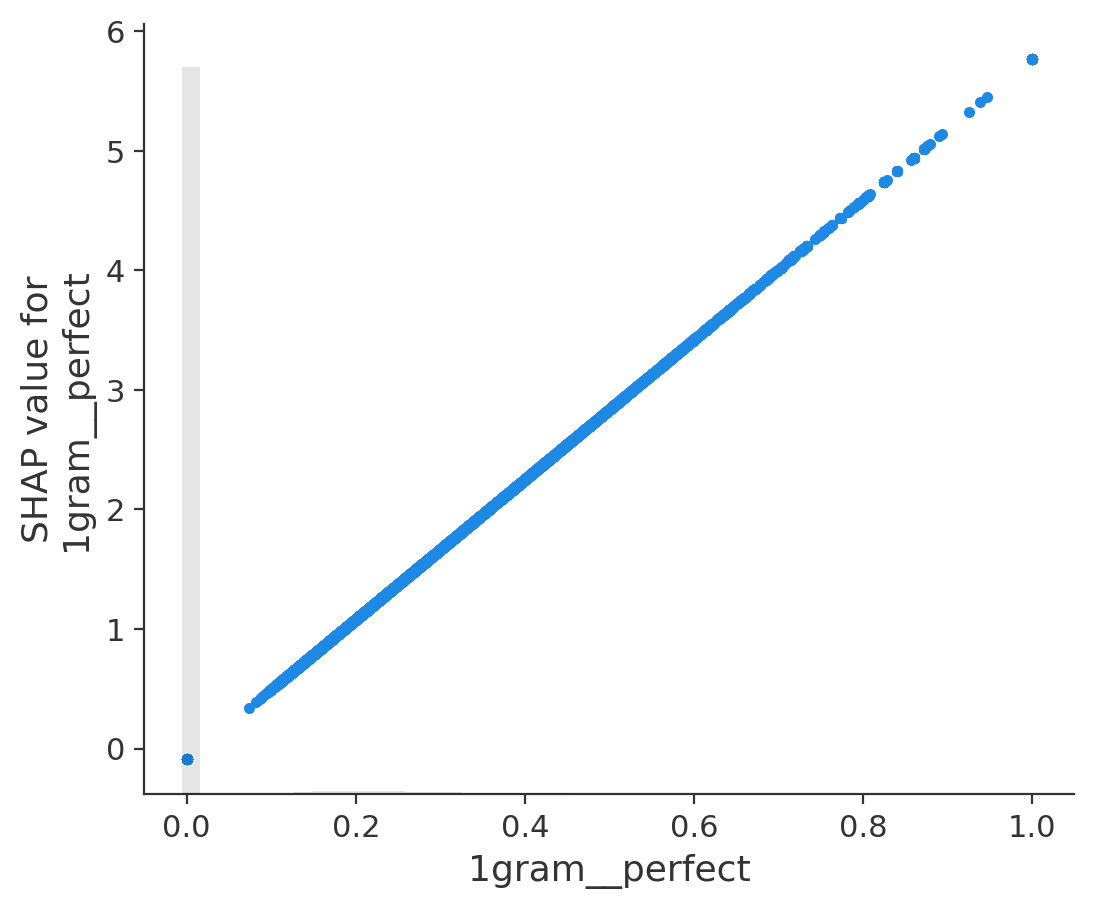

In [252]:
shap.plots.scatter(shap_values[:,"1gram__perfect"])


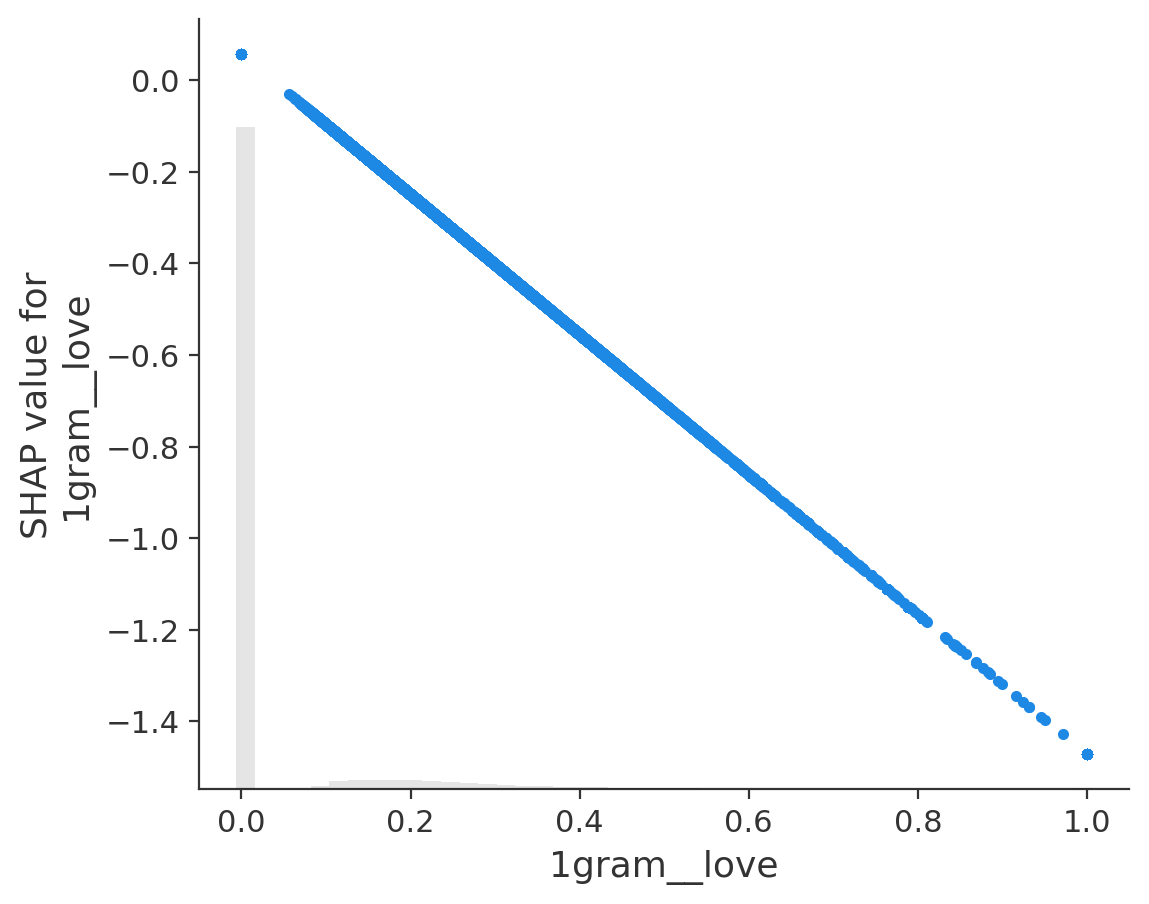

In [253]:
shap.plots.scatter(shap_values[:,"1gram__love"])


In [256]:
shap.plots.force(shap_values[position])

In [262]:
explainer_bal = shap.Explainer(
    pipe_final_bal[1], X_train_bal, feature_names=pipe_final_bal[0].get_feature_names_out(), index=X_train_bal.index
)
shap_values_bal = explainer_bal(X_test)

In [265]:
shap.plots.force(shap_values_bal[position])

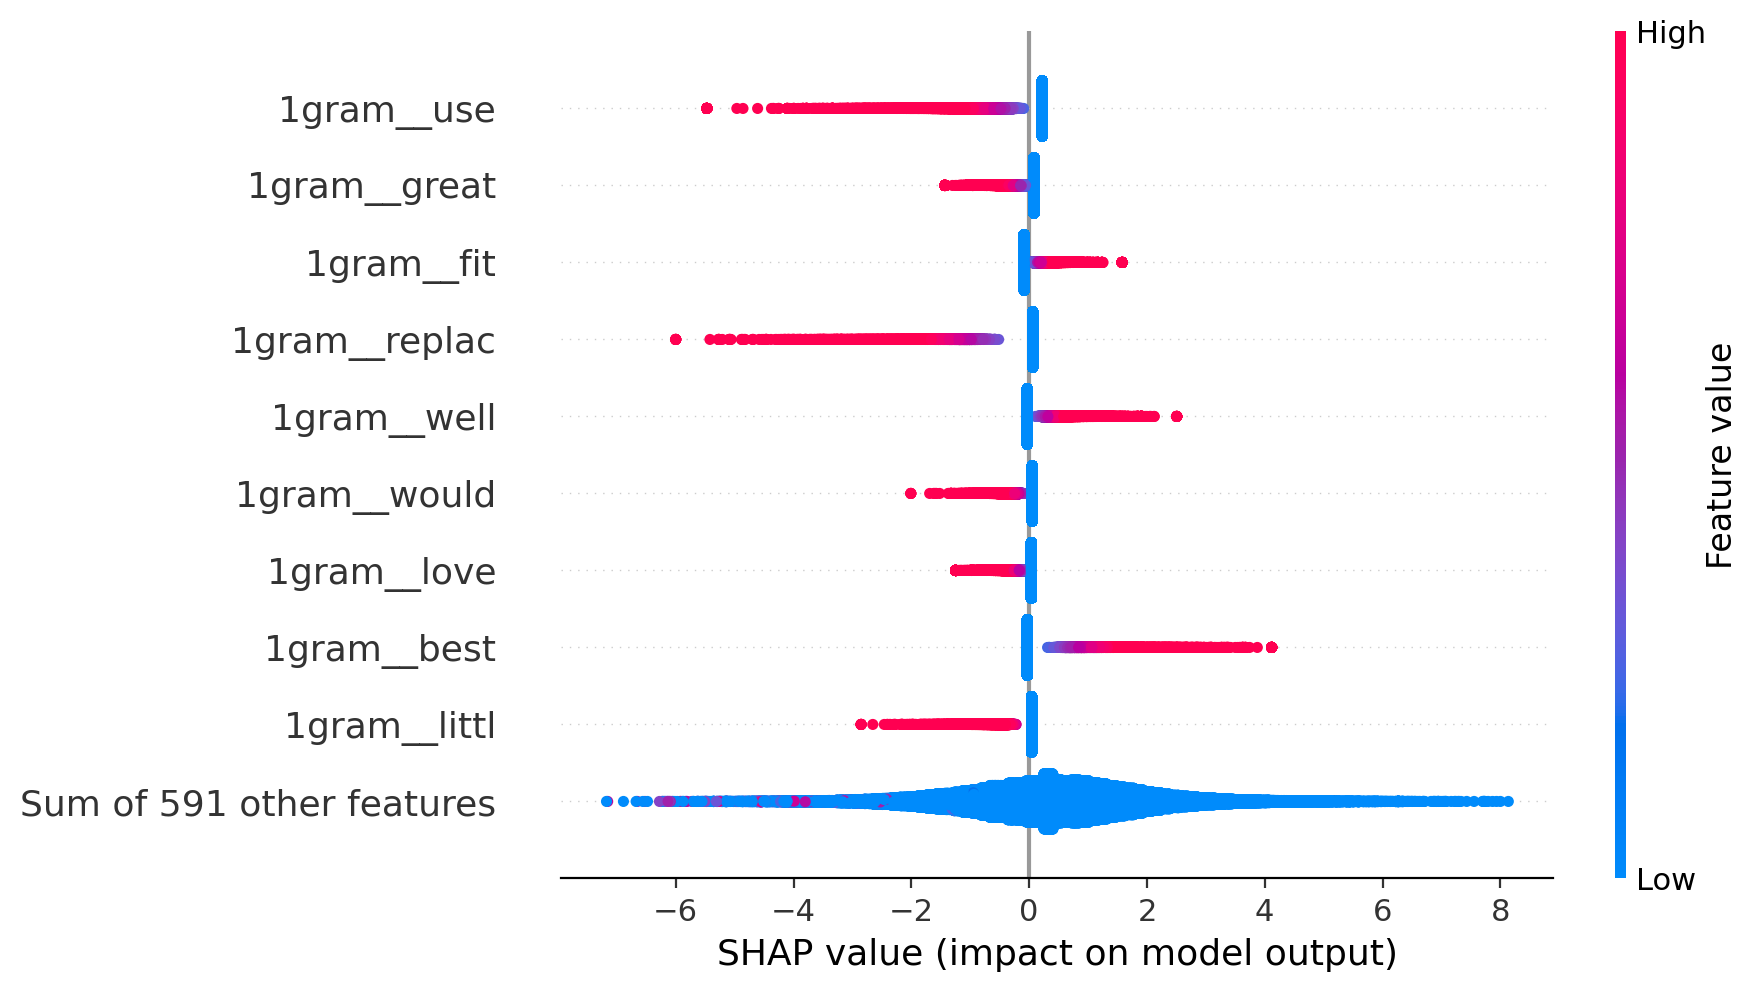

In [263]:
shap.plots.beeswarm(shap_values_bal)

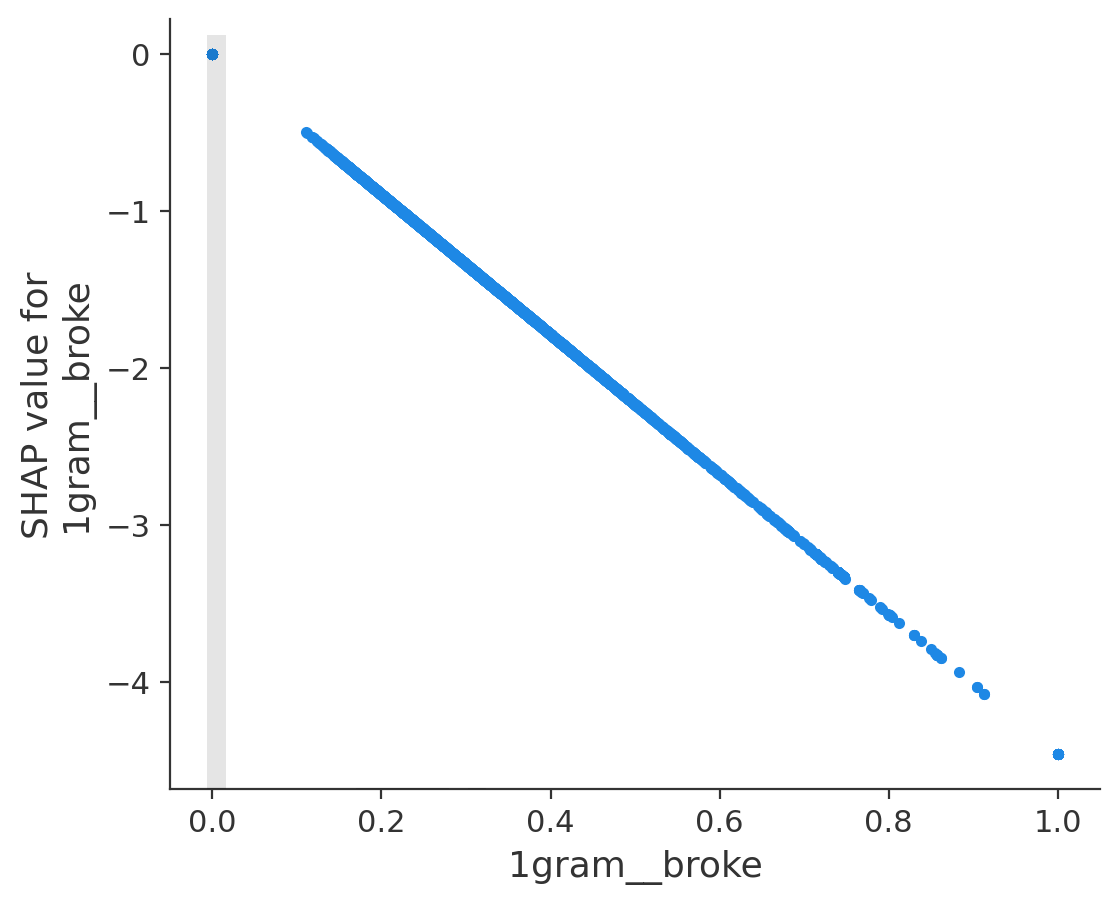

In [264]:
shap.plots.scatter(shap_values_bal[:,"1gram__broke"])
